In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier 
#To install xgboost library use - !pip install xgboost 
from xgboost import XGBClassifier

In [2]:
carsData = pd.read_csv("Cars-dataset.csv")
carsData.shape

(418, 9)

In [3]:
carsData.head()

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0


In [4]:
carsData['Opt_service'].value_counts() # imbalanced dataset

0    383
1     35
Name: Opt_service, dtype: int64

In [5]:
carsData[carsData.notnull()] # no missing values

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0
...,...,...,...,...,...,...,...,...,...
413,29,Male,1,1,8,13.9,17.1,0,0
414,25,Male,1,0,3,9.9,17.2,0,0
415,27,Female,0,0,4,13.9,17.3,0,0
416,26,Male,1,1,2,9.9,17.7,0,0


In [6]:
carsData.describe() #fairly straight forward dataset in terms of distribution - no invalid values observed

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,27.334928,0.748804,0.260766,5.873206,15.418421,11.306220,0.205742,0.083732
std,4.153272,0.434221,0.439578,4.816110,9.660234,3.722143,0.404727,0.277317
min,18.000000,0.000000,0.000000,0.000000,6.500000,3.200000,0.000000,0.000000
25%,25.000000,0.250000,0.000000,3.000000,9.625000,8.600000,0.000000,0.000000
50%,27.000000,1.000000,0.000000,5.000000,13.000000,10.900000,0.000000,0.000000
75%,29.000000,1.000000,1.000000,8.000000,14.900000,13.575000,0.000000,0.000000
max,43.000000,1.000000,1.000000,24.000000,57.000000,23.400000,1.000000,1.000000


In [7]:
carsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


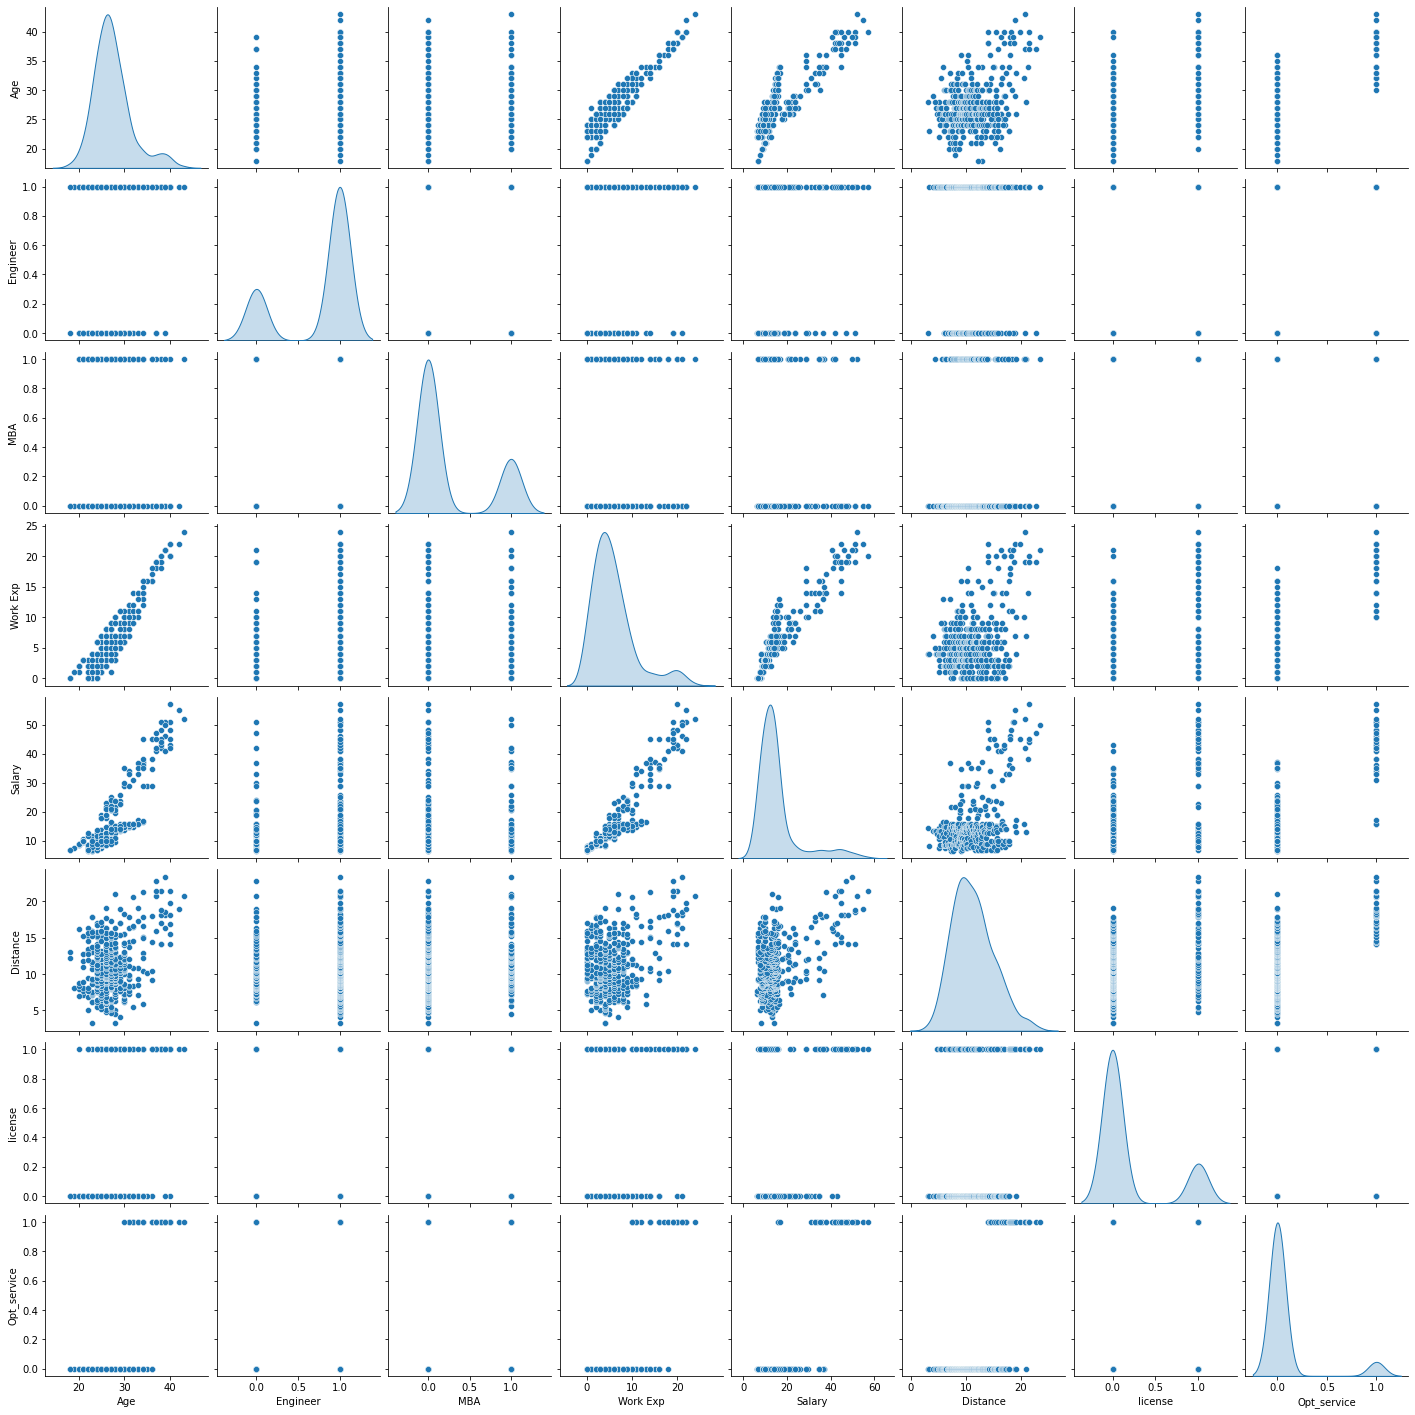

In [8]:
sns.pairplot(carsData, diag_kind='kde')

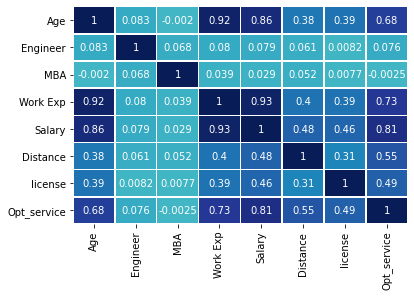

In [9]:
sns.heatmap(carsData.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

In [10]:
carsData = pd.get_dummies(carsData)

In [11]:
X = carsData.drop('Opt_service', axis=1)
y = carsData['Opt_service']
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)

In [12]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(418, 9)
(418,)
(292, 9)
(126, 9)
(292,)
(126,)


In [13]:
X_train.head()

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Gender_Female,Gender_Male
253,26,1,0,4,12.9,9.6,0,0,1
291,27,1,0,5,12.9,10.6,0,1,0
0,28,1,0,5,14.4,5.1,0,0,1
321,29,1,0,7,14.8,11.7,0,1,0
104,30,1,1,11,35.0,18.3,1,0,1


In [14]:
y_train.head()

253    0
291    0
0      0
321    0
104    1
Name: Opt_service, dtype: int64

In [15]:
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision, train_f1, test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print("F1-Score on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1-Score on test set : ",metrics.f1_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [16]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy on training set :  1.0
Accuracy on test set :  0.9603174603174603
Recall on training set :  1.0
Recall on test set :  0.9090909090909091
Precision on training set :  1.0
Precision on test set :  0.7142857142857143
F1-Score on training set :  1.0
F1-Score on test set :  0.8


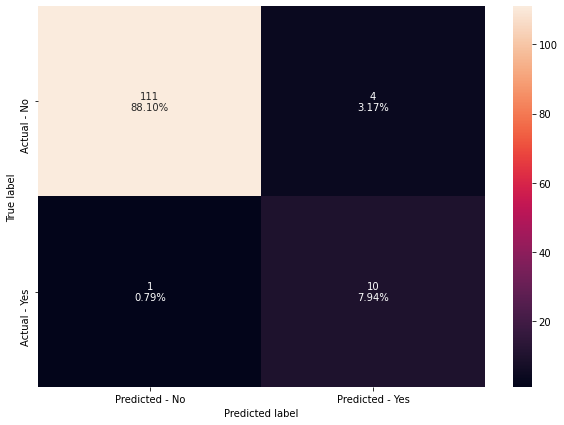

In [17]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(d_tree)

#Creating confusion matrix
make_confusion_matrix(d_tree,y_test)

Accuracy on training set :  0.9931506849315068
Accuracy on test set :  0.9365079365079365
Recall on training set :  0.9583333333333334
Recall on test set :  0.8181818181818182
Precision on training set :  0.9583333333333334
Precision on test set :  0.6
F1-Score on training set :  0.9583333333333334
F1-Score on test set :  0.6923076923076923


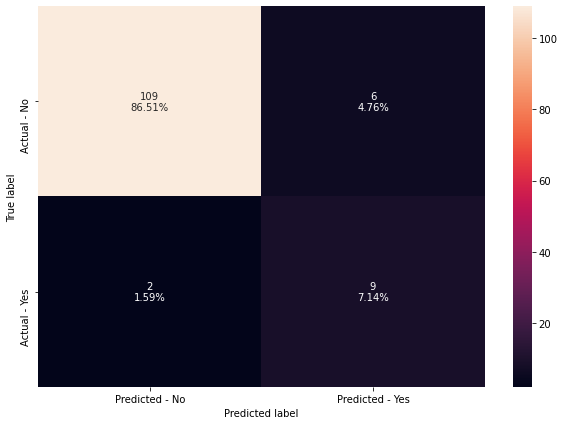

In [18]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)
get_metrics_score(dtree_estimator)
make_confusion_matrix(dtree_estimator,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9444444444444444
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.6428571428571429
F1-Score on training set :  1.0
F1-Score on test set :  0.7200000000000001


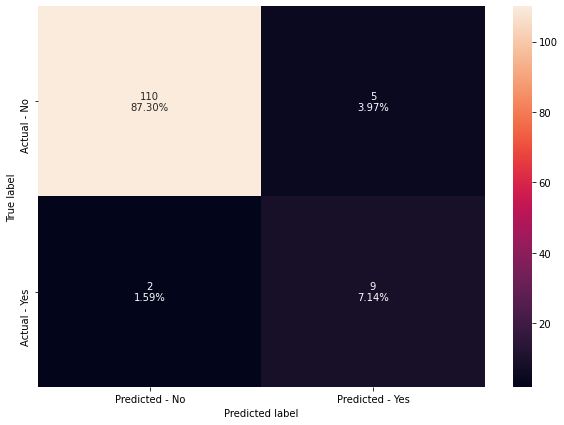

In [19]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(rf_estimator)

#Creating confusion matrix
make_confusion_matrix(rf_estimator,y_test)

Accuracy on training set :  0.9931506849315068
Accuracy on test set :  0.9444444444444444
Recall on training set :  0.9583333333333334
Recall on test set :  0.8181818181818182
Precision on training set :  0.9583333333333334
Precision on test set :  0.6428571428571429
F1-Score on training set :  0.9583333333333334
F1-Score on test set :  0.7200000000000001


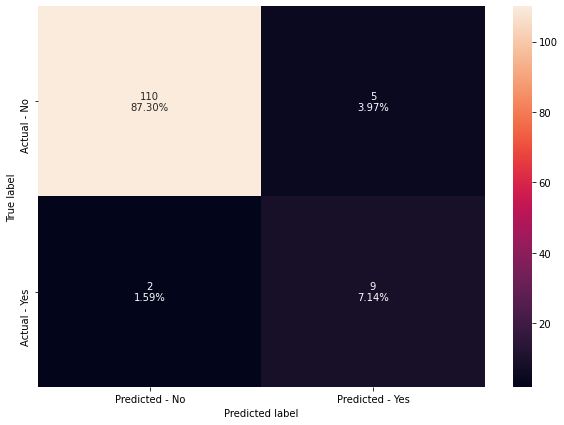

In [20]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)
#Calculating different metrics
get_metrics_score(rf_tuned)

#Creating confusion matrix
make_confusion_matrix(rf_tuned,y_test)

Accuracy on training set :  0.9965753424657534
Accuracy on test set :  0.9365079365079365
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  0.96
Precision on test set :  0.6
F1-Score on training set :  0.9795918367346939
F1-Score on test set :  0.6923076923076923


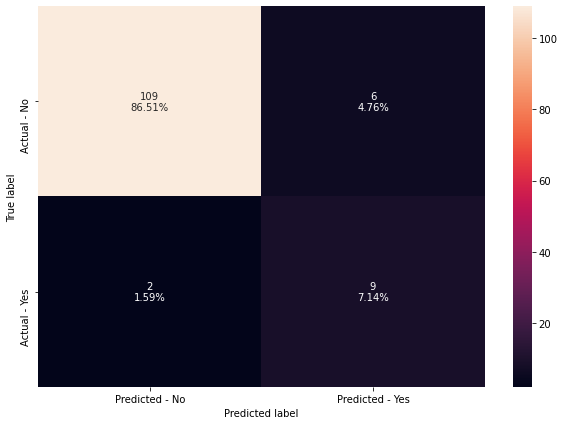

In [21]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(bagging_classifier)

#Creating confusion matrix
make_confusion_matrix(bagging_classifier,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9444444444444444
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.6428571428571429
F1-Score on training set :  1.0
F1-Score on test set :  0.7200000000000001


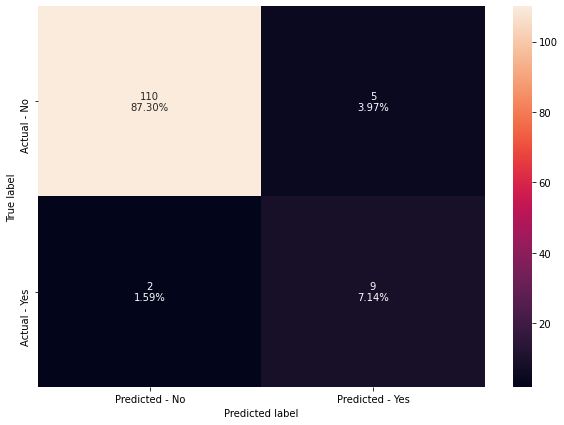

In [22]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)
#Calculating different metrics
get_metrics_score(bagging_estimator_tuned)

#Creating confusion matrix
make_confusion_matrix(bagging_estimator_tuned,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9682539682539683
Recall on training set :  1.0
Recall on test set :  0.7272727272727273
Precision on training set :  1.0
Precision on test set :  0.8888888888888888
F1-Score on training set :  1.0
F1-Score on test set :  0.7999999999999999


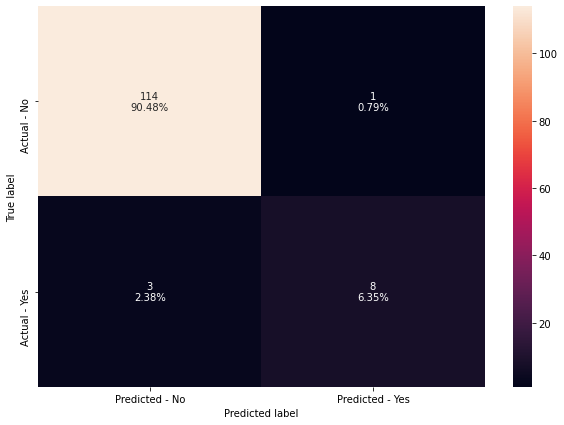

In [23]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier)

#Creating confusion matrix
make_confusion_matrix(ab_classifier,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9841269841269841
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  1.0
F1-Score on training set :  1.0
F1-Score on test set :  0.9


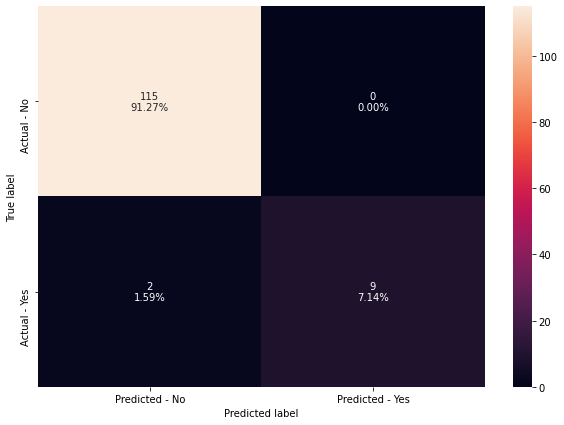

In [24]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)
#Calculating different metrics
get_metrics_score(abc_tuned)

#Creating confusion matrix
make_confusion_matrix(abc_tuned,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9603174603174603
Recall on training set :  1.0
Recall on test set :  0.9090909090909091
Precision on training set :  1.0
Precision on test set :  0.7142857142857143
F1-Score on training set :  1.0
F1-Score on test set :  0.8


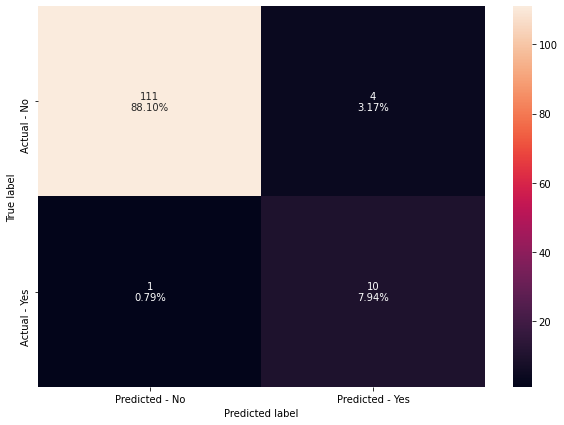

In [25]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(gb_classifier)

#Creating confusion matrix
make_confusion_matrix(gb_classifier,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9603174603174603
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.75
F1-Score on training set :  1.0
F1-Score on test set :  0.7826086956521738


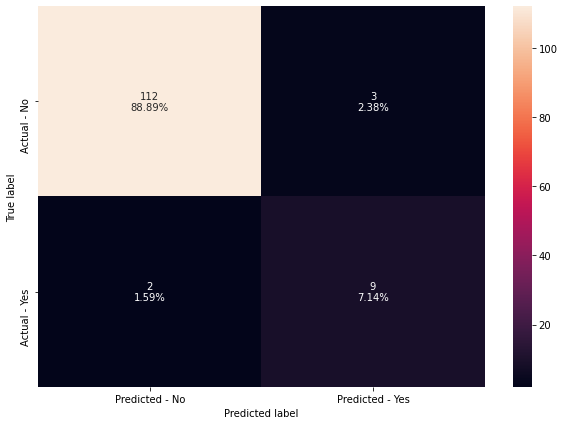

In [26]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(gbc_tuned)

#Creating confusion matrix
make_confusion_matrix(gbc_tuned,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9444444444444444
Recall on training set :  1.0
Recall on test set :  0.7272727272727273
Precision on training set :  1.0
Precision on test set :  0.6666666666666666
F1-Score on training set :  1.0
F1-Score on test set :  0.6956521739130435


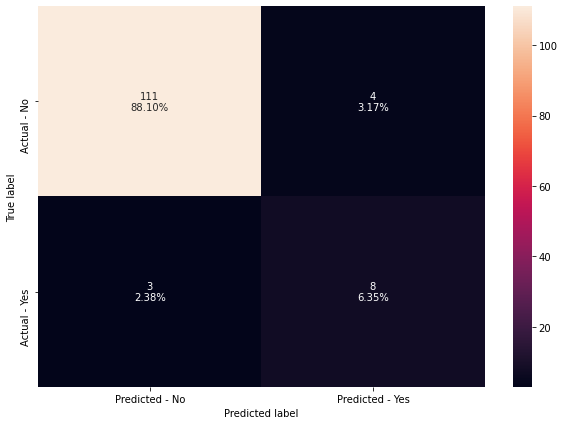

In [27]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(xgb_classifier)

#Creating confusion matrix
make_confusion_matrix(xgb_classifier,y_test)

Accuracy on training set :  0.9965753424657534
Accuracy on test set :  0.9444444444444444
Recall on training set :  0.9583333333333334
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.6428571428571429
F1-Score on training set :  0.9787234042553191
F1-Score on test set :  0.7200000000000001


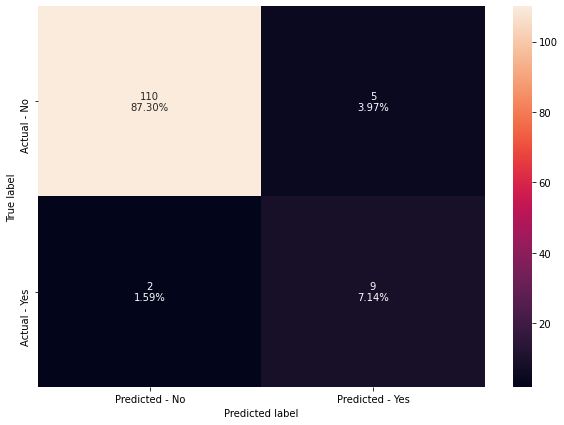

In [28]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(xgb_tuned)

#Creating confusion matrix
make_confusion_matrix(xgb_tuned,y_test)

Accuracy on training set :  0.9931506849315068
Accuracy on test set :  0.9444444444444444
Recall on training set :  0.9583333333333334
Recall on test set :  0.8181818181818182
Precision on training set :  0.9583333333333334
Precision on test set :  0.6428571428571429
F1-Score on training set :  0.9583333333333334
F1-Score on test set :  0.7200000000000001


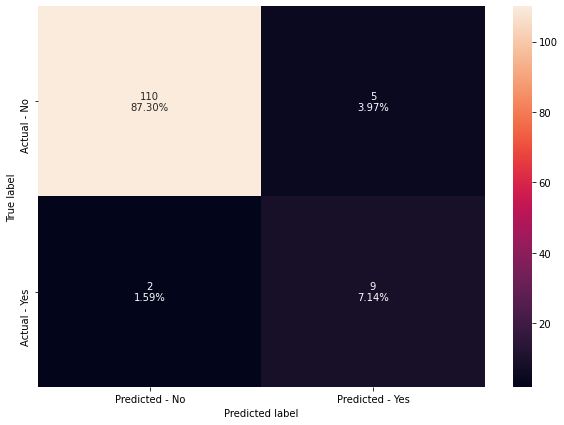

In [29]:
estimators = [('Random Forest',rf_tuned), ('Gradient Boosting',gbc_tuned), ('Decision Tree',dtree_estimator)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)
#Calculating different metrics
get_metrics_score(stacking_classifier)

#Creating confusion matrix
make_confusion_matrix(stacking_classifier,y_test)

In [31]:
# defining list of models
models = [d_tree, dtree_estimator,rf_estimator, rf_tuned, bagging_classifier,bagging_estimator_tuned,
          ab_classifier, abc_tuned, gb_classifier, gbc_tuned, xgb_classifier,xgb_tuned, stacking_classifier]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = [] 
f1_test = []

In [32]:
# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

In [33]:
comparison_frame = pd.DataFrame({'Model':['Decision Tree','Tuned Decision Tree','Random Forest','Tuned Random Forest',
                                          'Bagging Classifier','Bagging Classifier Tuned','AdaBoost Classifier','Tuned AdaBoost Classifier',
                                          'Gradient Boosting Classifier', 'Tuned Gradient Boosting Classifier',
                                          'XGBoost Classifier',  'Tuned XGBoost Classifier', 'Stacking Classifier'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                           'Train_F1-Score':f1_train, 'Test_F1-Score':f1_test})

In [35]:
#Sorting models in decreasing order of test recall
comparison_frame.sort_values(by='Test_F1-Score',ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1-Score,Test_F1-Score
7,Tuned AdaBoost Classifier,1.000000,0.984127,1.000000,0.818182,1.000000,1.000000,1.000000,0.900000
0,Decision Tree,1.000000,0.960317,1.000000,0.909091,1.000000,0.714286,1.000000,0.800000
8,Gradient Boosting Classifier,1.000000,0.960317,1.000000,0.909091,1.000000,0.714286,1.000000,0.800000
6,AdaBoost Classifier,1.000000,0.968254,1.000000,0.727273,1.000000,0.888889,1.000000,0.800000
9,Tuned Gradient Boosting Classifier,1.000000,0.960317,1.000000,0.818182,1.000000,0.750000,1.000000,0.782609
2,Random Forest,1.000000,0.944444,1.000000,0.818182,1.000000,0.642857,1.000000,0.720000
3,Tuned Random Forest,0.993151,0.944444,0.958333,0.818182,0.958333,0.642857,0.958333,0.720000
5,Bagging Classifier Tuned,1.000000,0.944444,1.000000,0.818182,1.000000,0.642857,1.000000,0.720000
11,Tuned XGBoost Classifier,0.996575,0.944444,0.958333,0.818182,1.000000,0.642857,0.978723,0.720000
12,Stacking Classifier,0.993151,0.944444,0.958333,0.818182,0.958333,0.642857,0.958333,0.720000


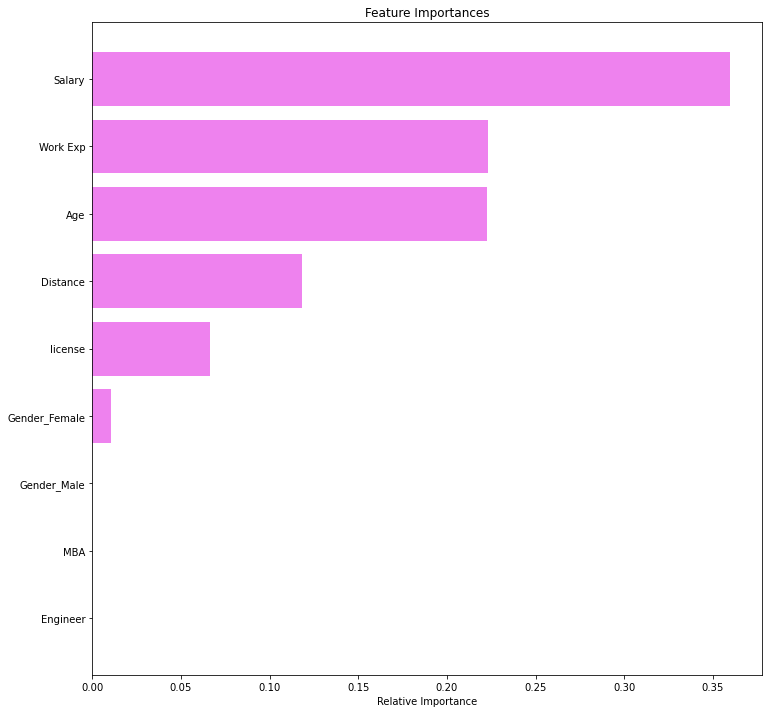

In [40]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [48]:
(y_test.value_counts()[0]/y_test.count()*100) - (y_test.value_counts()[1]/y_test.count()*100)

82.53968253968253

In [49]:
y_test.value_counts()[0]/y_test.count()*100

91.26984126984127

In [51]:
y_test.value_counts()[1]/y_test.count()*100

8.73015873015873

In [54]:
(y_train.value_counts()[0]/y_train.count()*100) - (y_train.value_counts()[1]/y_train.count()*100)

83.56164383561645

In [56]:
y_train.value_counts()

0    268
1     24
Name: Opt_service, dtype: int64

In [57]:
from sklearn.linear_model import LogisticRegression

Accuracy on training set :  0.9965753424657534
Accuracy on test set :  0.9682539682539683
Recall on training set :  0.9583333333333334
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.8181818181818182
F1-Score on training set :  0.9787234042553191
F1-Score on test set :  0.8181818181818182


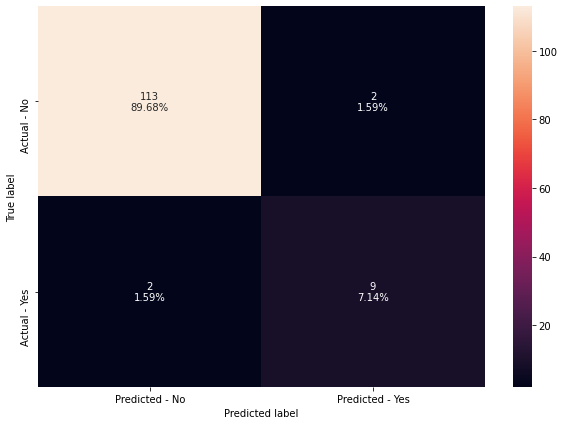

In [61]:
logistic = LogisticRegression()
#Fitting the model
bagging_classifier1 = BaggingClassifier(random_state=1, base_estimator = logistic)
bagging_classifier1.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(bagging_classifier1)

#Creating confusion matrix
make_confusion_matrix(bagging_classifier1,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9444444444444444
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.6428571428571429
F1-Score on training set :  1.0
F1-Score on test set :  0.7200000000000001


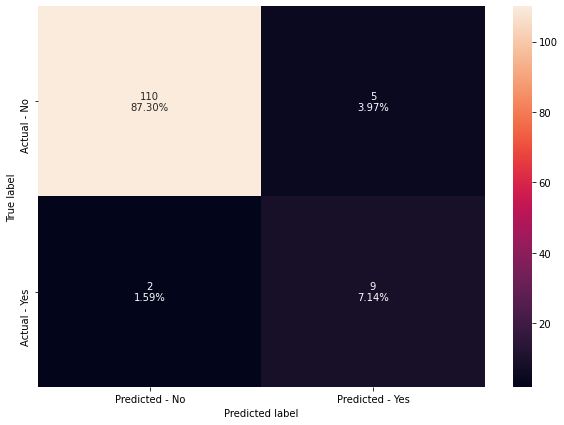

In [62]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(rf_estimator)

#Creating confusion matrix
make_confusion_matrix(rf_estimator,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9682539682539683
Recall on training set :  1.0
Recall on test set :  0.7272727272727273
Precision on training set :  1.0
Precision on test set :  0.8888888888888888
F1-Score on training set :  1.0
F1-Score on test set :  0.7999999999999999


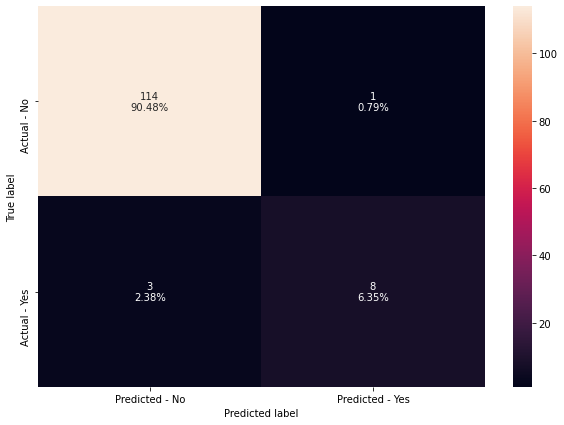

In [66]:
#Fitting the model
ab_classifier1 = AdaBoostClassifier(random_state=1, base_estimator=DecisionTreeClassifier(max_depth=1))
ab_classifier1.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier1)

#Creating confusion matrix
make_confusion_matrix(ab_classifier1,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9682539682539683
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.8181818181818182
F1-Score on training set :  1.0
F1-Score on test set :  0.8181818181818182


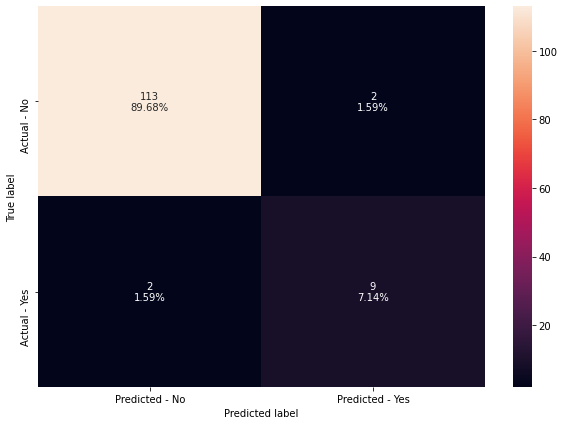

In [67]:
#Fitting the model
ab_classifier2 = AdaBoostClassifier(random_state=1, base_estimator=DecisionTreeClassifier(max_depth=2))
ab_classifier2.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier2)

#Creating confusion matrix
make_confusion_matrix(ab_classifier2,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9523809523809523
Recall on training set :  1.0
Recall on test set :  0.8181818181818182
Precision on training set :  1.0
Precision on test set :  0.6923076923076923
F1-Score on training set :  1.0
F1-Score on test set :  0.7500000000000001


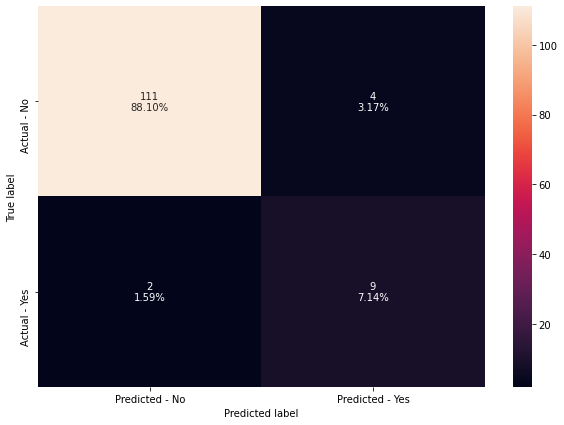

In [68]:
#Fitting the model
ab_classifier3 = AdaBoostClassifier(random_state=1, base_estimator=DecisionTreeClassifier(max_depth=3))
ab_classifier3.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier3)

#Creating confusion matrix
make_confusion_matrix(ab_classifier3,y_test)

{'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}
Accuracy on training set :  0.9897260273972602
Accuracy on test set :  0.9365079365079365
Recall on training set :  0.875
Recall on test set :  0.7272727272727273
Precision on training set :  1.0
Precision on test set :  0.6153846153846154
F1-Score on training set :  0.9333333333333333
F1-Score on test set :  0.6666666666666667


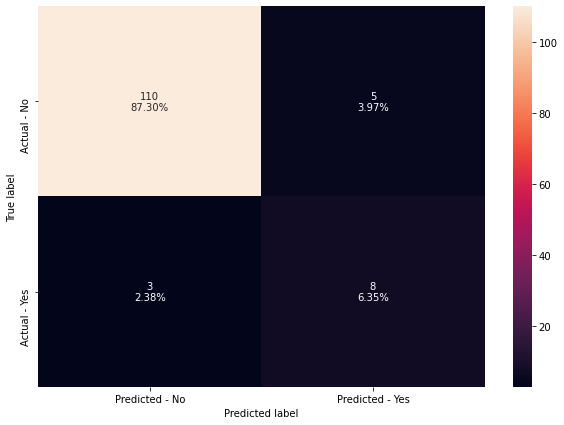

In [85]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(random_state=1)

parameters = {  
                'max_depth': list(np.arange(2,3, None)),
                'min_samples_split': np.arange(2,5,7),
                'n_estimators': np.arange(10,30,70)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_train, y_train)

print(grid_obj.best_params_)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)
#Calculating different metrics
get_metrics_score(rf_tuned)

#Creating confusion matrix
make_confusion_matrix(rf_tuned,y_test)

Accuracy on training set :  0.9965753424657534
Accuracy on test set :  0.9761904761904762
Recall on training set :  0.9583333333333334
Recall on test set :  0.9090909090909091
Precision on training set :  1.0
Precision on test set :  0.8333333333333334
F1-Score on training set :  0.9787234042553191
F1-Score on test set :  0.8695652173913043


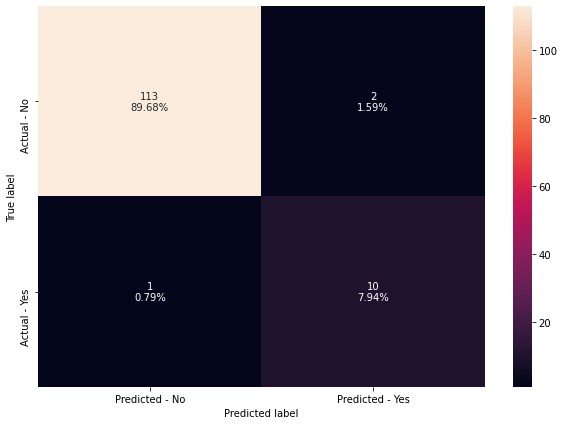

In [78]:
random_forest = RandomForestClassifier(random_state=1)
ada_boost = AdaBoostClassifier(random_state=1)
logistic_classifier = LogisticRegression()
estimators = [('Random Forest',random_forest), ('Ada Boosting',ada_boost), ('Logistic Classifier',logistic_classifier)]

final_estimator = GradientBoostingClassifier(random_state=1)

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)
#Calculating different metrics
get_metrics_score(stacking_classifier)

#Creating confusion matrix
make_confusion_matrix(stacking_classifier,y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9682539682539683
Recall on training set :  1.0
Recall on test set :  0.7272727272727273
Precision on training set :  1.0
Precision on test set :  0.8888888888888888
F1-Score on training set :  1.0
F1-Score on test set :  0.7999999999999999


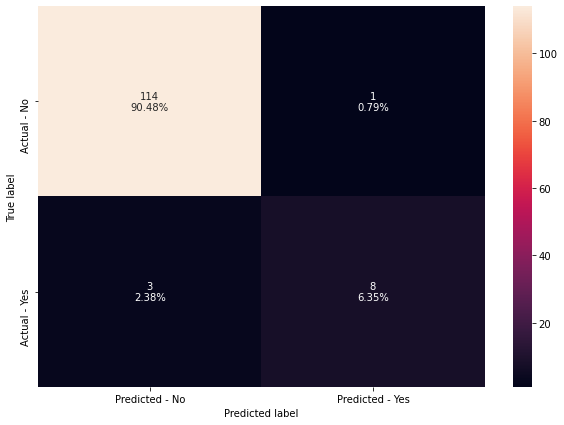

In [79]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier)

#Creating confusion matrix
make_confusion_matrix(ab_classifier,y_test)

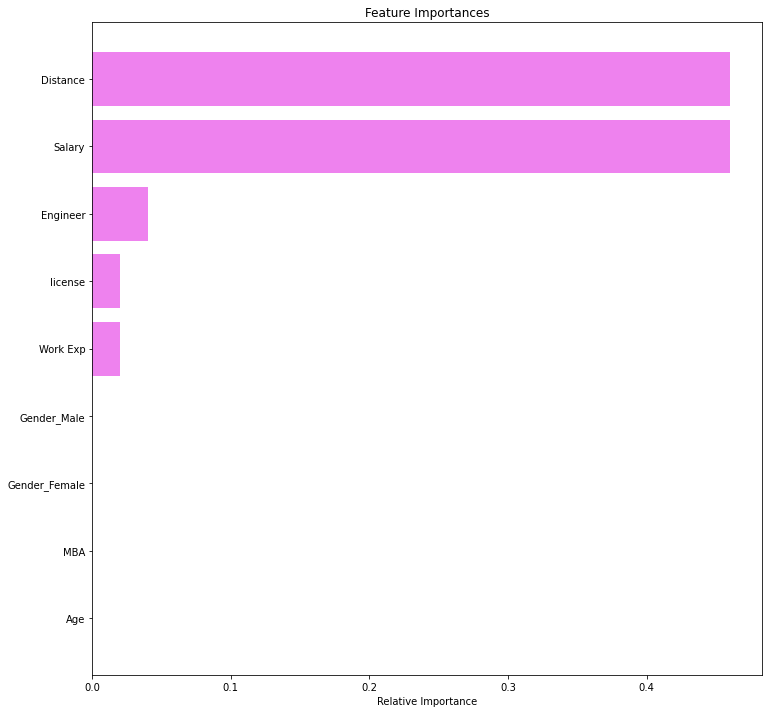

In [80]:
feature_names = X_train.columns
importances = ab_classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()